# Finding an Event in a Bundesliga match
An event is classified as either a **play**, a **throw-in**, or a **challenge**.
  - **Play**: a player's attempt to switch ball control to another member of his team. (Pass or Cross and Open play, Corner kick, or Free kick)
  - **Throw-In**: game restarted after the ball went out of play over the sideline following the touch of the opposite team
  - **Challenge**: player action during which two players of opposing teams are attempting to gain control of the ball. (Opponent rounded, ball action carried out, fouled, opponent dispossessed, challenge during release, possesion retained)

This is the first model in the pipeline and will attempt to classify the time of the event and what event it was.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio 
import cv2
import os

from fastai.data.all import *
from fastai.vision.all import *

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video
from tqdm.notebook import tqdm


In [2]:
data_path = Path('data/')
train_df = pd.read_csv(data_path/'train.csv')
train_df.head()

seed=42

In [3]:
train_df = train_df[(train_df['event'] == 'challenge') | (train_df['event'] == 'throwin') | (train_df['event'] == 'play')]
train_df.groupby(['event']).count()

,video_id,time,event_attributes
event,,,
challenge,624,624,624
play,3586,3586,3586
throwin,172,172,172


In [4]:
df_throwin = train_df[train_df['event'] == 'throwin'].copy()
df_play = train_df[train_df['event'] == 'play'].copy()
df_challenge = train_df[train_df['event'] == 'challenge'].copy()

Since the training data is so skewed, my theory is that there should be three different models, one binary classifier for each one.

### Binary Classifier for Throw-Ins
Let's first check out some throw-in clips and see the frame they identify as the event time

In [5]:
df_throwin.head()

,video_id,time,event,event_attributes
7,1606b0e6_0,219.23,throwin,['pass']
101,1606b0e6_0,427.67,throwin,['pass']
119,1606b0e6_0,474.39,throwin,['cross']
162,1606b0e6_0,621.11,throwin,['cross']
265,1606b0e6_0,875.39,throwin,['pass']


In [67]:
def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"train_{row.name}.mp4"
    ffmpeg_extract_subclip(
        f'data/train/{row["video_id"]}.mp4',
        #f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        row['time'] - before, 
        row['time'] + after, 
        targetname=filename,
    )
    
    return Video(filename, width=800)

In [71]:
p = data_path/'throwin'
if not os.path.exists(p):
    os.makedirs(p)
r = df_throwin.iloc[1]
vis_event(r,0.15,0.15)

['pass']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [8]:
df_throwin.iloc[0].name

7

In [9]:
videoFile = data_path/'train'/r['video_id']
video = cv2.VideoCapture(f'{videoFile}.mp4')
fps = video.get(cv2.CAP_PROP_FPS)

In [10]:
video

< cv2.VideoCapture 00000259EA103CF0>

In [11]:
for i, frame in enumerate(iio.imiter('train_101.mp4')):
    print(f'Mean of frame {i} is {frame.mean()}')

Mean of frame 0 is 98.09102928883745
Mean of frame 1 is 98.15089747299383
Mean of frame 2 is 97.77954057355967
Mean of frame 3 is 97.96800186471194
Mean of frame 4 is 97.83196534207819
Mean of frame 5 is 97.8193320794753
Mean of frame 6 is 97.47333895961934
Mean of frame 7 is 97.4341997813786
Mean of frame 8 is 97.26749453446502
Mean of frame 9 is 97.30942901234567
Mean of frame 10 is 96.93794962062758
Mean of frame 11 is 97.06974311985597
Mean of frame 12 is 96.86650977366256
Mean of frame 13 is 96.86531667952674
Mean of frame 14 is 96.5330753279321
Mean of frame 15 is 96.63168016975308
Mean of frame 16 is 96.31106497556584
Mean of frame 17 is 96.36667325745884
Mean of frame 18 is 96.06637474279836
Mean of frame 19 is 96.3888800475823
Mean of frame 20 is 96.3003554205247
Mean of frame 21 is 96.43874292695473
Mean of frame 22 is 96.20867621527778
Mean of frame 23 is 96.560262345679
Mean of frame 24 is 96.52112991898149
Mean of frame 25 is 96.44310378086419
Mean of frame 26 is 96.292522

In [12]:
# get frame number of event
int(r['time'] * fps)

10691

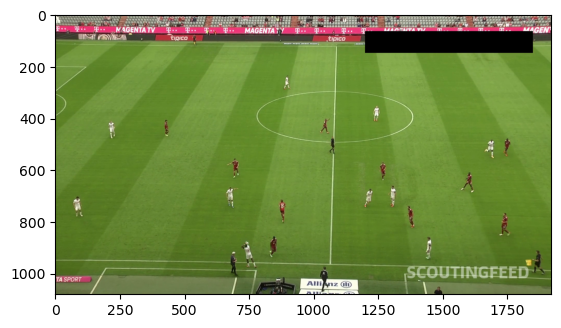

In [13]:
image = iio.imread(f'{videoFile}.mp4', index=int(r['time'] * fps))
plt.imshow(image)

In [14]:
train_meta = {}
def get_image(vid_id, time):
    video_file = data_path/'train'/vid_id
    try:
        fps = train_meta[vid_id]
    except KeyError:
        video = cv2.VideoCapture(f'{video_file}.mp4')
        fps = video.get(cv2.CAP_PROP_FPS)
        train_meta[vid_id] = fps
    frame = int(time * fps)
    p = data_path/vid_id
    if not os.path.exists(p):
        os.makedirs(p)
    if not os.path.exists(p/f'{frame}.png'):
        image = iio.imread(f'{video_file}.mp4', index=frame)
        iio.imwrite(p/f'{frame}.png', image)
    return p/f'{frame}.png'

In [15]:
# positive throwin dataset
fnames = [get_image(v, t) for v, t in tqdm(zip(df_throwin['video_id'], df_throwin['time']), total=len(df_throwin))]
df_throwin['fname'] = fnames

  0%|          | 0/172 [00:00<?, ?it/s]

In [16]:
# positive challenge dataset
fnames = [get_image(v, t) for v, t in tqdm(zip(df_challenge['video_id'], df_challenge['time']), total=len(df_challenge))]
df_challenge['fname'] = fnames

  0%|          | 0/624 [00:00<?, ?it/s]

In [17]:
# positive play dataset
fnames = [get_image(v, t) for v, t in tqdm(zip(df_play['video_id'], df_play['time']), total=len(df_play))]
df_play['fname'] = fnames

  0%|          | 0/3586 [00:00<?, ?it/s]

## Creating Datablocks for training

In [32]:
# after training on single image, try training on sequence of images within scoring tolerances
df_train = pd.DataFrame(df_throwin.fname.copy())
df_train['label'] = ['throwin'] * len(df_throwin)
len(df_train)

172

In [56]:
tmp_neg = pd.DataFrame(df_challenge.fname.copy())
tmp_neg['label'] = ['no_throwin'] * len(df_challenge)
df_train = pd.concat([df_train, tmp_neg])
'''tmp_neg = pd.DataFrame(df_play.fname.copy())
tmp_neg['label'] = ['no_throwin'] * len(df_play)
df_train = pd.concat([df_train, tmp_neg])
df_train.head()'''

"tmp_neg = pd.DataFrame(df_play.fname.copy())\ntmp_neg['label'] = ['no_throwin'] * len(df_play)\ndf_train = pd.concat([df_train, tmp_neg])\ndf_train.head()"

In [57]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                    get_x=lambda x:f'{x[0]}',
                    get_y=lambda x:f'{x[1]}',
                    splitter=RandomSplitter(seed=seed),
                    item_tfms=Resize(224),
                    batch_tfms=aug_transforms())

dls = dblock.dataloaders(df_train, num_workers=0)

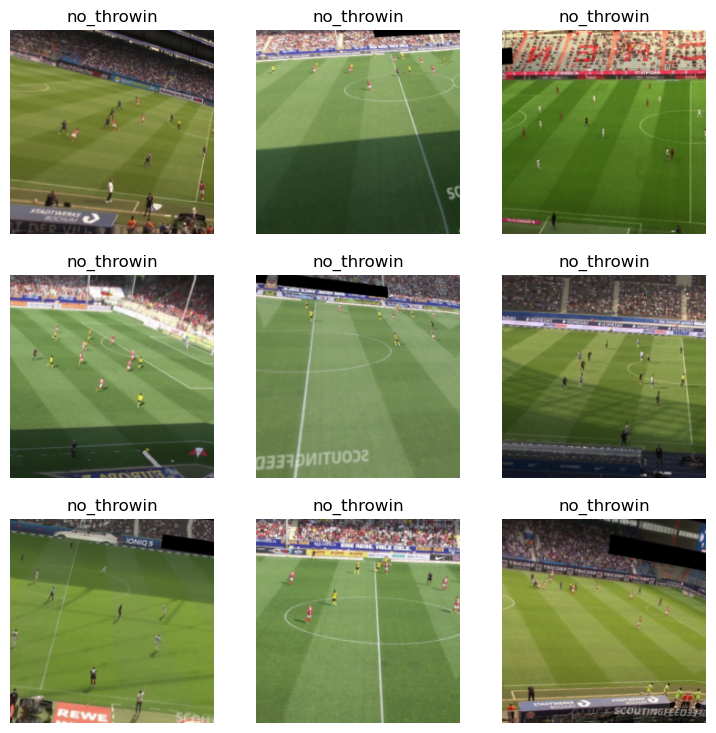

In [58]:
dls.show_batch()

In [59]:
learn = vision_learner(dls, resnet34, metrics=[F1Score(), error_rate])

c:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.002511886414140463)

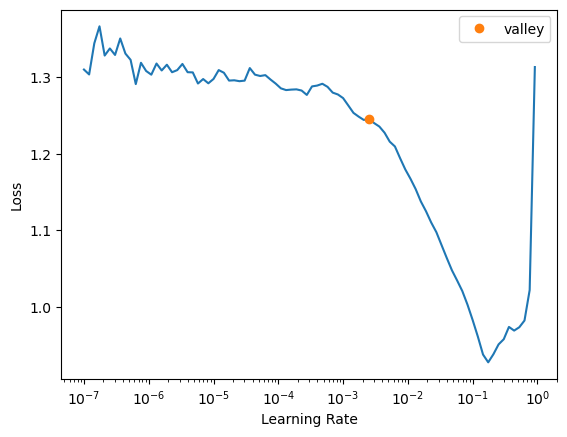

In [61]:
learn.lr_find()

In [62]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,f1_score,error_rate,time
0,0.719456,0.258404,0.067568,0.110400,09:20


epoch,train_loss,valid_loss,f1_score,error_rate,time
0,0.243806,0.157179,0.000000,0.026400,09:38
1,0.190918,0.100914,0.000000,0.020800,09:05


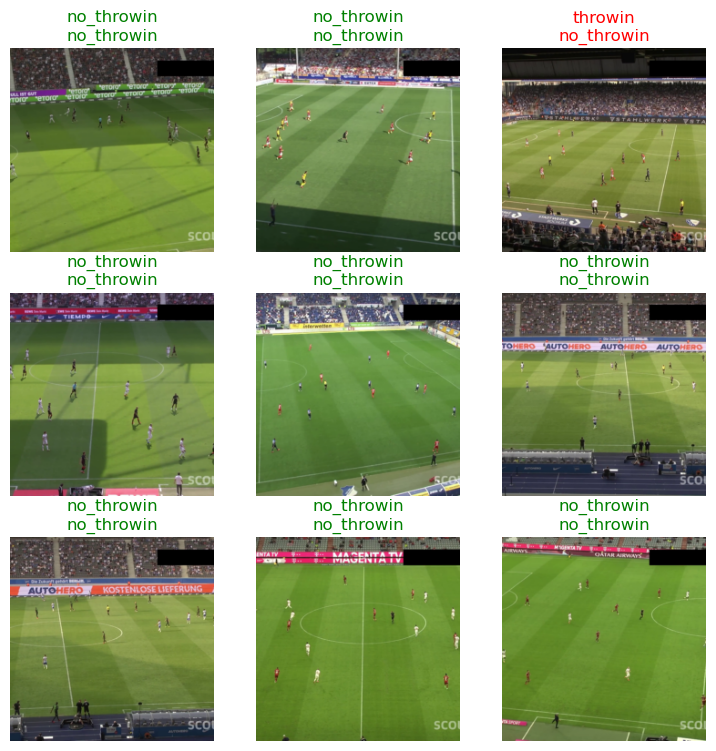

In [63]:
learn.show_results()

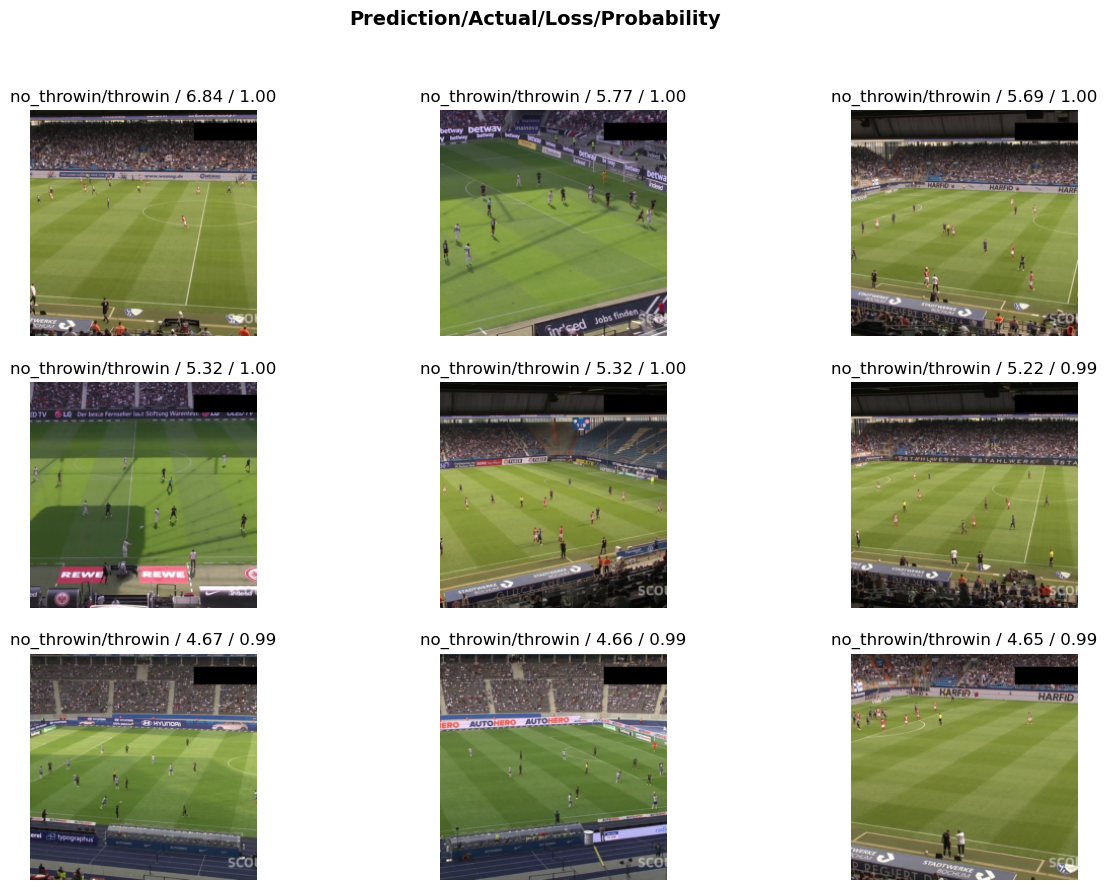

In [64]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))